# ZTF Events and Observations

The goal of this notebook is to estimate the number of microlensing events we can expect ZTF to discover during the lifetime of a Key Project. 

This estimate is based on the catalog of 60 events published by Rodriguez et al. 2022 2022ApJ...927..150R.  

In [16]:
from os import path
import csv
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
def read_event_list(event_file_path):
    data = []
    with open(event_file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            s = SkyCoord(row[1], row[2], frame='icrs', unit=(u.hourangle, u.deg))
            data.append(row + [s])
    data = np.array(data)

    event_table = Table(
                        [Column(data=data[:,0], name='Event'),
                        Column(data=data[:,1], name='RA'),
                        Column(data=data[:,2], name='Dec'),
                        Column(data=data[:,3], name='Coordinate')]
                        )

    return event_table

Reading in this list of events, we can calculate the number of lensing events detected each year.

In [3]:
event_file_path = 'ztf_event_list.csv'
ztf_events = read_event_list(event_file_path)


In [4]:
def count_events_per_year(event_set):
    events_per_year = {}
    uid_events = 0
    for event in event_set:
        # ZTF events have been assigned names in a variety of formats, not all of which include the
        # year they were discovered.  Sigh.  Going to parse as many of them as possible.
        name = str(event['Event'])
        if name[0:3] == 'ZTF' and name[3:4] in ['1', '2']:
            year = '20' + name[3:5]
        elif name[0:2] == 'AT' and name[2:3] in ['1', '2']:
            year = name[2:6]
        else:
            uid_events += 1
            year = '9999'
        
        if year != '9999':
            if year not in events_per_year.keys():
                events_per_year[year] = 1
            else:
                events_per_year[year] += 1

    for key, value in events_per_year.items():
        print(str(key)+': '+str(value)+' events')
    print(str(uid_events)+' events with year unidentified')

Now let's take a look at the expected rate of discoveries, bearing in mind that the survey and the alert system took a while to ramp up to the best rate of discoveries. 

In [5]:
print('Events per year discovered in DR 14 data:')
count_events_per_year(ztf_events)

Events per year discovered in DR 14 data:
2019: 25 events
2020: 17 events
2018: 11 events
7 events with year unidentified


Rodriguez et al. noted 3 events showing parallax signatures, and no binaries. 

## Expected number of events within a Key Project

From this it is clear that the rate of discovery is quite variable, but we can expect between 10-25 events per year.  **We adopt a conservative estimate of 15 events/year.**  

Based on the kp_simulator simulation, LCO would be able to observe 99% of all ZTF discovered events.  Rodriguez doesn't give an estimate of the expected fraction of stellar remnant events, so we use the figure of 7.9% of events derived from the Gaia catalog.  **This implies approximately 4-5 such lenses over the Key Project duration.**  

In [6]:
n_ztf_events = 15 # Per year
frac_bh_events = 0.073
frac_stellar_events = 0.927
obs_frac = 0.99
n_years = 3

n_stellar_per_year = int(round((n_ztf_events * frac_stellar_events * obs_frac),0))
n_bh_per_year = int(round((n_ztf_events * frac_bh_events * obs_frac),0))
n_stellar = n_stellar_per_year * n_years
n_bh = n_bh_per_year * n_years

print('Number of stellar events: '+str(n_stellar_per_year)+' per year, '+str(n_stellar)+' in total')
print('Number of stellar remnant events: '+str(n_bh_per_year)+' per year, '+str(n_bh)+' in total')



Number of stellar events: 14 per year, 42 in total
Number of stellar remnant events: 1 per year, 3 in total


In [7]:
frac_binary_events = 0.1
n_binary_events_obs = int(round((frac_binary_events * frac_stellar_events * n_ztf_events * obs_frac),0))
print('We expect ~'+str(round(n_binary_events_obs,0))+' binary events to be observable during the lifetime of the Key Project')


We expect ~1 binary events to be observable during the lifetime of the Key Project


## Observing Time Required

We can use the simulations of the Key Project observing strategy to estimate the total time required to observe ZTF events. The kp_simulator notebook generated a simulated set of 1000 events, and stored the simulated data products, which we read in here.  

In [8]:
def read_sim_event_table(file_path):
    hdul = fits.open(file_path)
    cols = hdul[1].columns
    data = hdul[1].data
    column_list = []
    for col in cols:
        if col.name == 'EventID':
            dtype = 'str'
        elif col.name in ['HEALpixel', 'nvisits']:
            dtype = 'int'
        else:
            dtype = 'float'
        column_list.append(Column(name=col.name, data=data[col.name], dtype=dtype))
    
    return Table(column_list)

In [9]:
def read_lco_sim_data(file_path, n_events):
    f = h5py.File(file_path, "r")
    dataset = {}
    for eventid in f.keys():
        dataset[eventid] = f[eventid][:]
    
    return dataset

In [10]:
sim_lco_lc_file = '../simulated_lco_lightcurves_ztf_events.hdf5'
dataset = read_lco_sim_data(sim_lco_lc_file, 1000)

In [11]:
sim_data_file = '../sim_ztf_events_table.fits'
events_table = read_sim_event_table(sim_data_file)

In [12]:
events_table

EventID,HEALpixel,RA_deg,Dec_deg,baseline_mag,t0,u0,tE,rho,piEN,piEE,nvisits_g,nvisits_r,nvisits_i,binary_lens
str14,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTFSim00001,14420,298.828125,24.624317169189453,14.21500015258789,2460505.75,0.14710761606693268,103.79735565185547,0.02320869266986847,-0.6835642457008362,-0.29413145780563354,781.0,1336.0,228.0,1.0
ZTFSim00002,19526,279.140625,12.024697303771973,13.21500015258789,2460281.5,0.38019534945487976,13.853976249694824,0.01959758996963501,-0.3672749996185303,0.1324736773967743,300.0,894.0,12.0,0.0
ZTFSim00003,27717,277.734375,-7.180755615234375,21.21500015258789,2460946.25,-0.5074136257171631,15.483811378479004,0.017264313995838165,-0.47007378935813904,0.48189055919647217,252.0,689.0,186.0,1.0
ZTFSim00004,14419,297.421875,24.624317169189453,22.21500015258789,2460488.0,-0.09993750602006912,7.520219326019287,0.00790835078805685,-0.08803141117095947,0.00027279031928628683,405.0,618.0,121.0,0.0
ZTFSim00005,28992,270.0,-10.19991683959961,22.21500015258789,2460275.5,0.08596441894769669,21.234373092651367,0.016479186713695526,1.3205761909484863,-0.09221053868532181,129.0,389.0,0.0,0.0
ZTFSim00006,30795,286.171875,-14.477511405944824,22.21500015258789,2460322.0,-0.173980250954628,63.24384689331055,0.000998964998871088,-0.9082760810852051,0.20405808091163635,117.0,500.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,31799,258.046875,-16.957761764526367,21.21500015258789,2461076.75,0.27235788106918335,67.6797866821289,0.01689186692237854,0.7442512512207031,0.3551871180534363,105.0,432.0,0.0,0.0
ZTFSim00995,13908,298.828125,25.944477081298828,22.21500015258789,2461140.25,0.05603725463151932,52.830238342285156,0.024515565484762192,-0.5026636123657227,0.6433686017990112,787.0,1340.0,229.0,0.0


Selecting the long timescale events with tE > 100d, we can use the simulated LCO lightcurves produced by the Key Project observing strategy, to estimate the typical number of visits to target that we can expect.  We can also use the same data to estimate the total exposure time per target, since the simulation includes target brightness as a function of time.  In order to estimate realistic exposure times on LCO 1m telescopes for targets at these magnitudes, we use the following empirical function, which was derived from previous LCO 1m photometry. 

In [13]:
def ETC(magin):
    """
    This function calculates the required exposure time
    for a given iband magnitude (e.g. OGLE I which also
    roughly matches SDSS i) based on a fit to the empiric
    LCO photometry.  Adapted from code by Markus Hundertmark.
    """
    
    mag = np.zeros(len(magin))
    mag[:] = magin
    
    # Cap the exposures at the bright end to minimise scintillation noise (min 5s)
    idx = np.where(magin < 14.7)
    mag[idx] = 14.7

    lrms = 0.14075464 * mag * mag - 4.00137342 * mag + 24.17513298
    snr = 1.0 / np.exp(lrms)

    # target 4% -> snr 25
    exptime = np.round((25. / snr)**2 * 300.,1)
    
    #Avoid exposures longer than 5min:
    idx = np.where(exptime > 300.0)
    exptime[idx] = 300.0

    return  exptime

In addition to the open-shutter time required during each visit to target, we need to account for telescope slew, instrument readout etc.  Based on the LCO instrumentation website (https://lco.global/observatory/instruments/), the overheads per frame for the LCO 1m Sinistro cameras is 28s.  So we add this to each exposure. 

In [14]:
def estimate_obs_time(event_set, events_table, dataset, nobs_cut=False):
    
    lco_obs_time = []
    lco_nvisits = []
    
    for ievent in event_set:
        event_name = events_table[ievent]['EventID']
        lco_lc = dataset[event_name]
        
        # Include only events that have been well studied
        accept = True
        if nobs_cut: 
            accept = False
            if len(lco_lc) > 100:
                accept = True
        
        if accept:
            lco_nvisits.append(len(lco_lc))

            # Calculate the exposure time per visit based on the target magnitude at the time, then 
            # add the instrumental overheads
            if len(lco_lc) > 0:
                lco_exposures = ETC(lco_lc[:,1])
                lco_exposures += 28.0
            else:
                lco_exposures = np.zeros(1)

            lco_obs_time.append(lco_exposures.sum())
        
    lco_nvisits = np.array(lco_nvisits)
    lco_obs_time = np.array(lco_obs_time)/3600.0

    return lco_nvisits, lco_obs_time


Median number of LCO visits per event: 496.0 for 73 events
Median total LCO exposure time per event: 9.34133333333333hrs
Mean number of LCO visits per event: 489.64383561643837 for 73 events
Mean total LCO exposure time per event: 9.221625570776252hrs


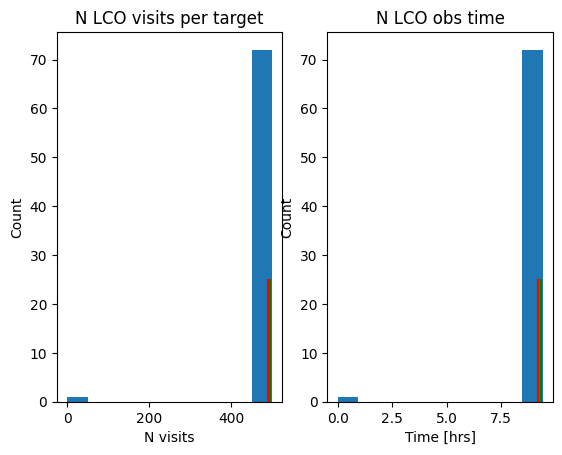

In [19]:
# Get the table indices of long-duration events
bh_events = np.where(events_table['tE'] > 100.0)[0]

# Estimate the number of visits per target and observing time required:
(lco_nvisits_bh, lco_obs_time_bh) = estimate_obs_time(bh_events, events_table, dataset, nobs_cut=False)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits_bh)
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
#axs[0].set_xlim([0,1000])
axs[1].hist(lco_obs_time_bh)
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')

time_per_bh_lens = np.median(lco_obs_time_bh)
avg_time_per_bh_lens = lco_obs_time_bh.mean()
visits_per_bh_lens = np.median(lco_nvisits_bh)
avg_visits_per_bh_lens = lco_nvisits_bh.mean()

axs[0].plot([visits_per_bh_lens,visits_per_bh_lens],
            [0,25], 'g-')
axs[0].plot([avg_visits_per_bh_lens,avg_visits_per_bh_lens],
            [0,25], 'r-')
axs[1].plot([time_per_bh_lens,time_per_bh_lens],
            [0,25], 'g-')
axs[1].plot([avg_time_per_bh_lens,avg_time_per_bh_lens],
            [0,25], 'r-')

print('Median number of LCO visits per event: '+str(visits_per_bh_lens)+' for '+str(len(bh_events))+' events')
print('Median total LCO exposure time per event: '+str(time_per_bh_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_bh_lens)+' for '+str(len(bh_events))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_bh_lens)+'hrs')



In [20]:
total_time_bh_events = n_bh * avg_time_per_bh_lens
print('The expected sample of '+str(n_bh)+' long-duration events is therefore estimated to required a total of '+str(round(total_time_bh_events,0))+'hrs')
       

The expected sample of 3 long-duration events is therefore estimated to required a total of 28.0hrs


To estimate the time required for stellar binary events, we adopt a similar approach, but select the correspondingly shorter timescale events from the simulated sample.

Median number of LCO visits per event: 182.5 for 840 events
Median total LCO exposure time per event: 3.437083333333333hrs
Mean number of LCO visits per event: 223.73333333333332 for 840 events
Mean total LCO exposure time per event: 4.213644444444444hrs


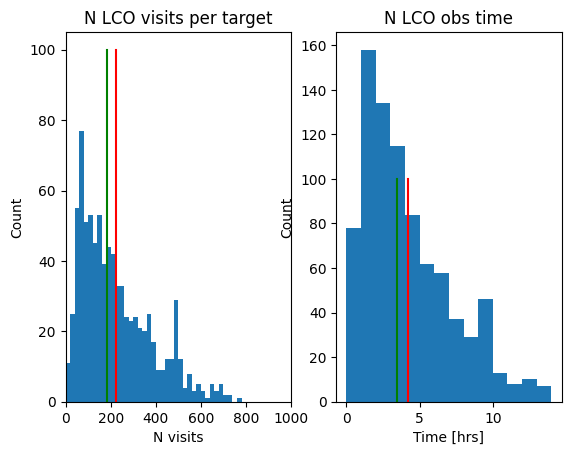

In [21]:
# Get the table indices of stellar events
#stellar_events = np.where(events_table['tE'] < 100.0)[0]
stellar_lenses = np.where(events_table['tE'] < 100.0)[0]
single_lenses = np.where(events_table['binary_lens'] == 0)[0]
single_stellar_lenses = list(set(stellar_lenses).intersection(set(single_lenses)))


# Estimate the number of visits per target and observing time required:
(lco_nvisits, lco_obs_time) = estimate_obs_time(single_stellar_lenses, events_table, dataset)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits, bins=np.arange(0, 1000 ,20))
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
axs[0].set_xlim([0,1000])
axs[1].hist(lco_obs_time, bins=np.arange(0, lco_obs_time.max(),1))
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')

time_per_single_lens = np.median(lco_obs_time)
avg_time_per_single_lens = lco_obs_time.mean()
visits_per_single_lens = np.median(lco_nvisits)
avg_visits_per_single_lens = lco_nvisits.mean()

axs[0].plot([visits_per_single_lens,visits_per_single_lens],
            [0,100], 'g-')
axs[0].plot([avg_visits_per_single_lens,avg_visits_per_single_lens],
            [0,100], 'r-')
axs[1].plot([time_per_single_lens,time_per_single_lens],
            [0,100], 'g-')
axs[1].plot([avg_time_per_single_lens,avg_time_per_single_lens],
            [0,100], 'r-')

print('Median number of LCO visits per event: '+str(np.median(lco_nvisits))+' for '+str(len(single_stellar_lenses))+' events')
print('Median total LCO exposure time per event: '+str(time_per_single_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_single_lens)+' for '+str(len(single_stellar_lenses))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_single_lens)+'hrs')



In [22]:
total_time_stellar_events = n_stellar * avg_time_per_single_lens
print('The expected sample of '+str(n_stellar)+' stellar events is therefore estimated to required a total of '+str(round(total_time_stellar_events,0))+'hrs')


The expected sample of 42 stellar events is therefore estimated to required a total of 177.0hrs


Median number of LCO visits per event: 320.0 for 87 events
Median total LCO exposure time per event: 6.0266666666666655hrs
Mean number of LCO visits per event: 342.97701149425285 for 87 events
Mean total LCO exposure time per event: 6.459400383141761hrs


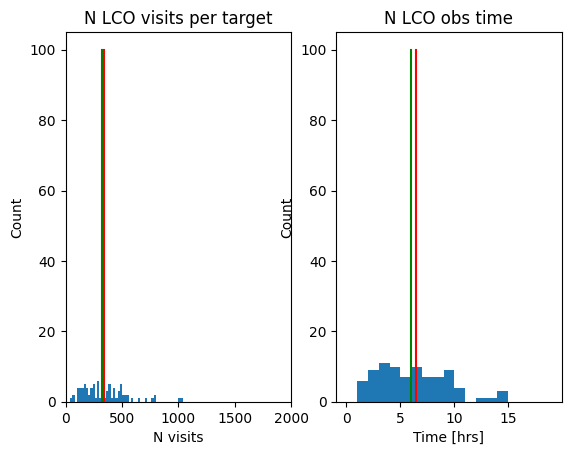

In [37]:
# Get the table indices of binary-lens stellar events
stellar_lenses = np.where(events_table['tE'] < 100.0)[0]
binary_lenses = np.where(events_table['binary_lens'] == 1)[0]
binary_stellar_lenses = list(set(stellar_lenses).intersection(set(binary_lenses)))

# Estimate the number of visits per target and observing time required:
(lco_nvisits_binary, lco_obs_time_binary) = estimate_obs_time(binary_stellar_lenses, events_table, dataset)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits_binary, bins=np.arange(0, 2000 ,20))
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
axs[0].set_xlim([0,2000])
axs[1].hist(lco_obs_time_binary, bins=np.arange(0, lco_obs_time_binary.max(),1))
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')

time_per_binary_lens = np.median(lco_obs_time_binary)
avg_time_per_binary_lens = lco_obs_time_binary.mean()
visits_per_binary_lens = np.median(lco_nvisits_binary)
avg_visits_per_binary_lens = lco_nvisits_binary.mean()

axs[0].plot([visits_per_binary_lens,visits_per_binary_lens],
            [0,100], 'g-')
axs[0].plot([avg_visits_per_binary_lens,avg_visits_per_binary_lens],
            [0,100], 'r-')
axs[1].plot([time_per_binary_lens,time_per_binary_lens],
            [0,100], 'g-')
axs[1].plot([avg_time_per_binary_lens,avg_time_per_binary_lens],
            [0,100], 'r-')

print('Median number of LCO visits per event: '+str(visits_per_binary_lens)+' for '+str(len(binary_stellar_lenses))+' events')
print('Median total LCO exposure time per event: '+str(time_per_binary_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_binary_lens)+' for '+str(len(binary_stellar_lenses))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_binary_lens)+'hrs')



In [38]:
total_time_binary_stellar_events = n_binary_events_obs * avg_time_per_binary_lens
print('The expected sample of '+str(n_binary_events_obs)+' binary-lens stellar events is estimated to required a total of '+str(round(total_time_binary_stellar_events,0))+'hrs')


The expected sample of 1 binary-lens stellar events is estimated to required a total of 6.0hrs


Binary lens events are allocated an additional 12hrs of high-cadence (every 15min) observations on top of the regular monitoring.

In [23]:
add_time_binary_events = n_binary_events_obs * 12.0
print('The '+str(n_binary_events_obs)+' binary events are estimated to require an additional '+str(round(add_time_binary_events,0))+'hrs')



The 1 binary events are estimated to require an additional 12.0hrs


In [24]:
total_time = total_time_bh_events + total_time_stellar_events + add_time_binary_events
print('In total, LCO observations of ZTF targets would be expected to require: '+str(total_time)+'hrs')

In total, LCO observations of ZTF targets would be expected to require: 216.6379433789954hrs


## Observations from the 2m Network and Rapid Response Observations
The 2m network offers the MusCAT multi-channel imagers and the FLOYDS spectrographs.  

While only a few targets will be accessible to FLOYDS (r<15mag), the spectra are extremely useful to constrain the source star parameters for all categories of microlensing event.  In order to distinguish the source star spectrum from neighboring objects, spectra at multiple epochs with different lensing magnifications are required, though not at the high cadence required for photometry.  We propose to obtain 3 spectra of selected targets that reach magnitudes brighter than 15mag (where FLOYDS can deliver S/N=100 in 1hr of exposure).  

We can estimate the potential number of FLOYDS targets using the simulated LCO lightcurve dataset, and identifing the fraction of targets likely to exceed 15mag.  

In [25]:
sim_survey_lc_file = '../simulated_ztf_lightcurves.hdf5'
survey_dataset = read_lco_sim_data(sim_survey_lc_file, 1000)

In [26]:
bright_events = []
n_survey_lc = 0
for ievent in range(0,len(survey_dataset),1):
    event_name = events_table[ievent]['EventID']
    
    survey_lc = dataset[event_name]
    if len(survey_lc) > 0:
        n_survey_lc += 1
        idx = np.where(survey_lc[:,1] < 15.0)[0]
        if len(idx) > 0:
            bright_events.append(ievent)

frac_bright_events = float(len(bright_events))/float(len(events_table))
print('Fraction of events accessible to FLOYDS = '+str(frac_bright_events))
print('Number of full survey lightcurve '+str(n_survey_lc))

Fraction of events accessible to FLOYDS = 0.995
Number of full survey lightcurve 995


In [29]:
n_targets = n_bh + n_stellar
n_FLOYDS_targets = int(round(n_targets * frac_bright_events,0))
print('Number of ZTF targets likely to be accessible to FLOYDS = '+str(n_FLOYDS_targets))

Number of ZTF targets likely to be accessible to FLOYDS = 45


Since there is a FLOYDS spectrograph in both hemispheres, the 2m network can observe any target while it is visible to our target surveys.  Of the stellar and BH targets we expect per year we expect to be able to observe ~ 2 with FLOYDS.  
Each FLOYDS observation will consist of a 1hr science exposure plus the LCO-recommended set of calibration exposures: 2x60s arc frames with the HgAr and Zn lamps for wavelength calibration and 2x70s flat field exposures with the Tungsten-Halogen + Xenon lamp, since we will use the 1.2" slit due to the crowding in this field.  Calibration frames will be requested both before and after each science spectrum.  

Following the overhead calculation recommended on the FLOYDS website for a 1hr science spectrum:
Initial setup and telescope slew is 120 s. 
Target acquisition is 90 s. 
Lamp flat exposures include an overhead of 60 s.
Arc lamp exposures include an overhead of 100 s. 
All configuration changes (from flat to arc to science spectrum) require a 16 s software setup overhead. 
Readout time is 26 s. 

In [30]:
# All times in s
tel_slew = 120.0
target_acquisition = 90.0
lamp_exp_overhead = 60.0
lamp_exp = 70.0
arc_exp_overhead = 100.0
arc_exp = 60.0
software = 16.0
readout = 26.0
science_exp = 3600.0

In [31]:
time_per_FLOYDS_visit = tel_slew + target_acquisition \
                    + lamp_exp_overhead + software + lamp_exp + readout \
                    + arc_exp_overhead + software + arc_exp + readout \
                    + software + science_exp + readout \
                    + lamp_exp_overhead + software + lamp_exp + readout \
                    + arc_exp_overhead + software + arc_exp + readout
time_per_FLOYDS_visit /= 60.0

print('Time required per FLOYDS visit to 1 target = '+str(time_per_FLOYDS_visit)+'min')

Time required per FLOYDS visit to 1 target = 76.66666666666667min


Taking 3 visits per FLOYDS target therefore requires a total request of (split 50:50 North/South):

In [32]:
total_FLOYDS_time = n_FLOYDS_targets * time_per_FLOYDS_visit * 3.0
total_FLOYDS_time /= 60.0

print('Total time = '+str(total_FLOYDS_time)+'hrs')

Total time = 172.5hrs


The MuSCAT four-channel imagers are particularly important for binary lens events, as they can deliver high-cadence multi-color observations of caustic crossings, short-lived, sharp discontinuities in the lightcurves that mark the entrance and exits of caustic crossings lasting ~ 6hrs.  It is extremely important to monitor their photometry continuously for that period in order to constrain the morphology of the lightcurve, which in turn constrains the models of the caustic structure and lens-source relative trajectory.  

While almost all of the observations from this program can be made in queue-scheduled mode, the short timescale and transient nature of these features require rapid response time to ensure that we can observe as soon as they are detected by our real-time modeling system.  They also justify observing from every site in the network to ensure as continuous coverage as possible.  For this reason, we request the following time on MuSCAT and some 1m time is allocated in Rapid Response mode.

Caustic crossings are only likely in the stellar binary events we expect from ZTF.  Adopting an average duration of 6hrs per caustic entrance and exit (i.e. 12hrs per target), we request in Rapid Response mode:

In [34]:
time_caustic = 6.0 # hrs, with two caustic crossings per event
time_rr_stellar_events = n_stellar * 2.0 * time_caustic
print('Rapid Response Time requested for stellar binary caustic crossings = '+str(time_rr_stellar_events)+'hrs')

Rapid Response Time requested for stellar binary caustic crossings = 504.0hrs


ZTF targets are accessible to FTN/MusCAT for up to 8hrs per day, or a day fraction of:

In [35]:
vis_fraction = 8.0 / 24.0
vis_fraction

0.3333333333333333

We therefore request that this fraction of the require rapid response time from the FTN/MusCAT imagers, with the remaining rapid response time coming from the 1m/Sinistro network. 

In [36]:
time_2m_imagers = time_rr_stellar_events * vis_fraction
print('Time on 2m imagers in Rapid Response mode = '+str(time_2m_imagers))

Time on 2m imagers in Rapid Response mode = 168.0
